# Creation of synthetic data for stroke thrombolysis pathway data set using SMOTE. Tested using a logistic regression model.

## Aim

To test a statistic method (principal component analysis) for synthesising data that can be used to train a logistic regression machine learning model.

## Data

Raw data is avilable at: 

https://raw.githubusercontent.com/MichaelAllen1966/1807_stroke_pathway/master/machine_learning/data/data_for_ml_clin_only.csv

## Basic methods description

* Create synthetic data by sampling from distributions based on SMOTE
* Train logistic regression model on synthetic data and test against held-back raw data

Lemaitre, G., Nogueira, F. and Aridas, C. (2016), Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning. arXiv:1609.06570 [cs]

## Code & results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Turn warnings off for notebook publication
import warnings
warnings.filterwarnings("ignore")

## Function to turn an array of float values into one-hot

In [2]:
def make_one_hot(x):
    """
    Takes a list/array/series and returns 1 for highest value and 0 for all 
    others
    
    """
    # Get argmax
    highest = np.argmax(x)
    # Set all values to zero
    x *= 0.0
    # Set argmax to one
    x[highest] = 1.0
    
    return x

### Import Data

In [3]:
def load_data():
    """"
    Load Stroke Pathway data set
    
    Inputs
    ------
    None
    
    Returns
    -------
    X: NumPy array of X
    y: Numpy array of y
    col_names: column names for X
    """    
    
    # Load data 
    data = pd.read_csv('./stroke_pathway.csv')
    
    # Shuffle data
    data = data.sample(frac=1)   

    # Change 'Thrombolysis given' column to 'thrombolysis', and put last
    data['label'] = data['Thrombolysis given']
    data.drop('Thrombolysis given', axis=1, inplace=True)

    # Split data in X and y
    X = data.drop(['label'], axis=1)
    y = data['label']
    
    # Get col names and convert to NumPy arrays
    X_col_names = list(X)
    X = X.values
    y = y.values
    
    return data, X, y, X_col_names 

### Data processing

Split X and y into training and test sets

In [4]:
def split_into_train_test(X, y, test_proportion=0.25):    
    """"
    Randomly split X and y numpy arrays into training and test data sets
    
    Inputs
    ------
    X and y NumPy arrays
    
    Returns
    -------
    X_test, X_train, y_test, y_train Numpy arrays
    """
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, shuffle=True, test_size=test_proportion)
        
    return X_train, X_test, y_train, y_test  

Standardise data

In [5]:
def standardise_data(X_train, X_test):
    """"
    Standardise training and tets data sets according to mean and standard
    deviation of test set
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    X_train_std, X_test_std
    """
    
    mu = X_train.mean(axis=0)
    # Add small amount to std to avoid divide by zero errors
    std = X_train.std(axis=0) + 1e-9
    
    X_train_std = (X_train - mu) / std
    X_test_std = (X_test - mu) /std
    
    return X_train_std, X_test_std
    

### Calculate accuracy measures

In [6]:
def calculate_diagnostic_performance(actual, predicted):
    """ Calculate sensitivty and specificty.
    
    Inputs
    ------
    actual, predted numpy arrays (1 = +ve, 0 = -ve)
    
    Returns
    -------
    A dictionary of results:
    
    1)  accuracy: proportion of test results that are correct    
    2)  sensitivity: proportion of true +ve identified
    3)  specificity: proportion of true -ve identified
    4)  positive likelihood: increased probability of true +ve if test +ve
    5)  negative likelihood: reduced probability of true +ve if test -ve
    6)  false positive rate: proportion of false +ves in true -ve patients
    7)  false negative rate:  proportion of false -ves in true +ve patients
    8)  positive predictive value: chance of true +ve if test +ve
    9)  negative predictive value: chance of true -ve if test -ve
    10) actual positive rate: proportion of actual values that are +ve
    11) predicted positive rate: proportion of predicted vales that are +ve
    12) recall: same as sensitivity
    13) precision: the proportion of predicted +ve that are true +ve
    14) f1 = 2 * ((precision * recall) / (precision + recall))

    *false positive rate is the percentage of healthy individuals who 
    incorrectly receive a positive test result
    * alse neagtive rate is the percentage of diseased individuals who 
    incorrectly receive a negative test result
    
    """
    
    # Calculate results 
    actual_positives = actual == 1
    actual_negatives = actual == 0
    test_positives = predicted == 1
    test_negatives = predicted == 0
    test_correct = actual == predicted
    accuracy = test_correct.mean()
    true_positives = actual_positives & test_positives
    false_positives = actual_negatives & test_positives
    true_negatives = actual_negatives & test_negatives
    sensitivity = true_positives.sum() / actual_positives.sum()
    specificity = np.sum(true_negatives) / np.sum(actual_negatives)
    positive_likelihood = sensitivity / (1 - specificity)
    negative_likelihood = (1 - sensitivity) / specificity
    false_postive_rate = 1 - specificity
    false_negative_rate = 1 - sensitivity
    positive_predictive_value = true_positives.sum() / test_positives.sum()
    negative_predicitive_value = true_negatives.sum() / test_negatives.sum()
    actual_positive_rate = actual.mean()
    predicted_positive_rate = predicted.mean()
    recall = sensitivity
    precision = \
        true_positives.sum() / (true_positives.sum() + false_positives.sum())
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    # Add results to dictionary
    results = dict()
    results['accuracy'] = accuracy
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_postive_rate'] = false_postive_rate
    results['false_postive_rate'] = false_postive_rate
    results['false_negative_rate'] = false_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predicitive_value'] = negative_predicitive_value
    results['actual_positive_rate'] = actual_positive_rate
    results['predicted_positive_rate'] = predicted_positive_rate
    results['recall'] = recall
    results['precision'] = precision
    results['f1'] = f1
   
    return results

### Logistic Regression Model

In [7]:
def fit_and_test_logistic_regression_model(X_train, X_test, y_train, y_test):    
    """"
    Fit and test logistic regression model. 
    Return a dictionary of accuracy measures.
    Calls on `calculate_diagnostic_performance` to calculate results
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    A dictionary of accuracy results.
    """
    
    # Fit logistic regression model 
    lr = LogisticRegression(C=0.1)
    lr.fit(X_train,y_train)

    # Predict tets set labels
    y_pred = lr.predict(X_test_std)
    
    # Get accuracy results
    accuracy_results = calculate_diagnostic_performance(y_test, y_pred)
    
    return accuracy_results

### Synthetic Data Method - SMOTE

In [8]:
def make_synthetic_data_smote(X, y, number_of_samples=1000):
    """
    Synthetic data generation.
        
    Inputs
    ------
    original_data: X, y numpy arrays
    number_of_samples: number of synthetic samples to generate
    n_components: number of principal components to use for data synthesis
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
    
    from imblearn.over_sampling import SMOTE
    
    count_label_0 = np.sum(y==0)
    count_label_1 = np.sum(y==1)
    
    n_class_0 = number_of_samples + count_label_0
    n_class_1 = number_of_samples + count_label_1

    X_resampled, y_resampled = SMOTE(
        sampling_strategy = {0:n_class_0, 1:n_class_1}).fit_resample(X, y)

    X_synthetic = X_resampled[len(X):]
    y_synthetic = y_resampled[len(y):]
                                                                   
    return X_synthetic, y_synthetic


### Main code

In [9]:
# Load data
original_data, X, y, X_col_names = load_data()

# Set up results DataFrame
results = pd.DataFrame()

In [10]:
# Set one hot columns

one_hot_cols = [[x for x in X_col_names if x[0:4] == 'Hosp'],
               [x for x in X_col_names if x[0:21] == 'Onset Time Known Type'],
               [x for x in X_col_names if x[0:21] == 'Stroke severity group'],
               [x for x in X_col_names if x[0:11] == 'Stroke Type'],
               [x for x in X_col_names if x[0:12] == 'Antiplatelet'],
               [x for x in X_col_names if x[0:22] == 'Anticoag before stroke']]

In [11]:
# Set integer and binary columns

integer_cols = ['Male',
                'Age',
                'Age_80',
                '# Comorbidities',
                '2+ comorbidotes',
                'Congestive HF',
                'Hypertension',
                'Atrial Fib',
                'Diabetes',
                'TIA',
                'Co-mordity',
                'S2RankinBeforeStroke',
                'S2NihssArrival',
                'S2NihssArrivalLocQuestions',
                'S2NihssArrivalLocCommands',
                'S2NihssArrivalBestGaze',
                'S2NihssArrivalVisual',
                'S2NihssArrivalFacialPalsy',
                'S2NihssArrivalMotorArmLeft',
                'S2NihssArrivalMotorArmRight',
                'S2NihssArrivalMotorLegLeft',
                'S2NihssArrivalMotorLegRight',
                'S2NihssArrivalLimbAtaxia',
                'S2NihssArrivalSensory',
                'S2NihssArrivalBestLanguage',
                'S2NihssArrivalDysarthria',
                'S2NihssArrivalExtinctionInattention']

binary_cols = ['Male',
                'Age_80',
                '2+ comorbidotes',
                'Congestive HF',
                'Hypertension',
                'Atrial Fib',
                'Diabetes',
                'TIA',
                'Co-mordity']

Fitting classification model to raw data

In [12]:
# Set number of replicate runs
number_of_runs = 5

# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')
    
    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data    
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_train, y_test)
    
    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)
    
    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)

# Strore mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['raw_mean'] = accuracy_array.mean(axis=0)
results['raw_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)
results.index = accuracy_measure_names
    

1 2 3 4 5 

Fitting classification model to synthetic data

In [13]:
# Set number of replicate runs
number_of_runs = 5

# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []
synthetic_data = []

for run in range(number_of_runs):
    
    # Get synthetic data
    X_synthetic, y_synthetic = make_synthetic_data_smote(
        X, y, number_of_samples=1000)    
  
    # Print progress
    print (run + 1, end=' ')
    
    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data (using synthetic data)
    X_train_std, X_test_std = standardise_data(X_synthetic, X_test)
    
    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_synthetic, y_test)
    
    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)
    
    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)
    
    # Save synthetic data set
    # -----------------------
    
    # Create a data frame with id
    synth_df = pd.DataFrame()
    
    # Transfer X values to DataFrame
    synth_df=pd.concat([synth_df, 
                        pd.DataFrame(X_synthetic, columns=X_col_names)],
                        axis=1)
    
    # Make one hot as necessary
    for one_hot_list in one_hot_cols:    
        for index, row in synth_df.iterrows():
            x = row[one_hot_list]
            x_one_hot = make_one_hot(x)
            row[x_one_hot.index]= x_one_hot.values
            
    # Make integer as necessary
    for col in integer_cols:
        synth_df[col] = synth_df[col].round(0)
        
    # Clip binary cols
    for col in binary_cols:
        synth_df[col] = np.clip(synth_df[col],0,1)

    # Add a label
    y_list = list(y_synthetic)
    synth_df['label'] = y_list

    # Shuffle data
    synth_df = synth_df.sample(frac=1.0)
    
    # Add to synthetic data results list
    synthetic_data.append(synth_df)

# Strore mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['smote_mean'] = accuracy_array.mean(axis=0)
results['smote_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)

1 2 3 4 5 

### Show results

In [14]:
results

,raw_mean,raw_sem,smote_mean,smote_sem
accuracy,0.793133,0.006665,0.824034,0.004249
sensitivity,0.765120,0.011203,0.853278,0.011559
specificity,0.811934,0.009206,0.803371,0.009682
positive_likelihood,4.125054,0.243175,4.377214,0.157776
negative_likelihood,0.289470,0.014193,0.182155,0.012889
false_postive_rate,0.188066,0.009206,0.196629,0.009682
false_negative_rate,0.234880,0.011203,0.146722,0.011559
positive_predictive_value,0.727291,0.016902,0.753688,0.008074
negative_predicitive_value,0.840217,0.006830,0.886841,0.006701
actual_positive_rate,0.396996,0.009992,0.412876,0.003722


## Compare raw and synthetic data means and standard deviations

In [15]:
descriptive_stats_all_runs = []

for run in range(number_of_runs):
    
    synth_df = synthetic_data[run]
  
    descriptive_stats = pd.DataFrame()

    descriptive_stats['Original pos_label mean'] = \
        original_data[original_data['label'] == 1].mean()

    descriptive_stats['Synthetic pos_label mean'] = \
        synth_df[synth_df['label'] == 1].mean()

    descriptive_stats['Original neg_label mean'] = \
        original_data[original_data['label'] == 0].mean()

    descriptive_stats['Synthetic neg_label mean'] = \
        synth_df[synth_df['label'] == 0].mean()

    descriptive_stats['Original pos_label std'] = \
        original_data[original_data['label'] == 1].std()

    descriptive_stats['Synthetic pos_label std'] = \
        synth_df[synth_df['label'] == 1].std()

    descriptive_stats['Original neg_label std'] = \
        original_data[original_data['label'] == 0].std()

    descriptive_stats['Synthetic neg_label std'] = \
        synth_df[synth_df['label'] == 0].std()
    
    descriptive_stats_all_runs.append(descriptive_stats)

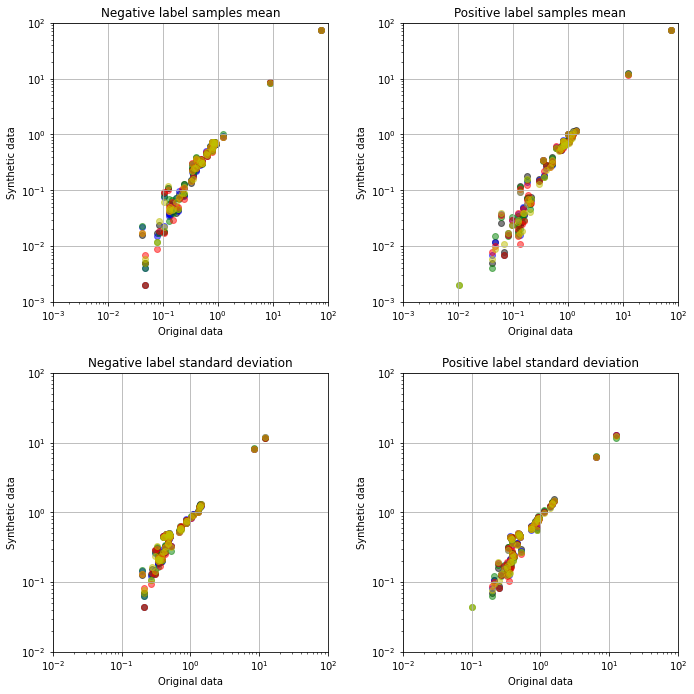

In [16]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,10))

# Note: Set x and y limits to avoid plotting values that are very close to zero

# Negative mean
ax1 = fig.add_subplot(221)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(x,y, color=colour, alpha=0.5)
ax1.set_xlabel('Original data')
ax1.set_ylabel('Synthetic data')
ax1.set_xlim(1e-3, 1e2)
ax1.set_ylim(1e-3, 1e2)
ax1.set_title('Negative label samples mean')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid()

# Positive mean
ax2 = fig.add_subplot(222)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(x,y, color=colour, alpha=0.5)
ax2.set_xlabel('Original data')
ax2.set_ylabel('Synthetic data')
ax2.set_title('Positive label samples mean')
ax2.set_xlim(1e-3, 1e2)
ax2.set_ylim(1e-3, 1e2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid()

# Negative standard deviation
ax3 = fig.add_subplot(223)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax3.scatter(x,y, color=colour, alpha=0.5)
ax3.set_xlabel('Original data')
ax3.set_ylabel('Synthetic data')
ax3.set_title('Negative label standard deviation')
ax3.set_xlim(1e-2, 1e2)
ax3.set_ylim(1e-2, 1e2)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.grid()

# Positive standard deviation
ax4 = fig.add_subplot(224)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax4.scatter(x,y, color=colour, alpha=0.5)
ax4.set_xlabel('Original data')
ax4.set_ylabel('Synthetic data')
ax4.set_title('Positive label standard deviation')
ax4.set_xlim(1e-2, 1e2)
ax4.set_ylim(1e-2, 1e2)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.grid()

plt.tight_layout(pad=2)
plt.savefig('Output/smote_correls.png', facecolor='w', dpi=300)
plt.show()

Calculate correlations between means and standard deviations for negative and positive classes.

In [17]:
correl_mean_neg = []
correl_std_neg = []
correl_mean_pos = []
correl_std_pos = []

for run in range(number_of_runs):
    # Get correlation of means
    x = descriptive_stats_all_runs[run]['Original neg_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean']
    correl_mean_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean']
    correl_mean_pos.append(np.corrcoef(x,y)[0,1])
    
    # Get correlation of standard deviations
    x = descriptive_stats_all_runs[run]['Original neg_label std']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std']
    correl_std_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label std']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std']
    correl_std_pos.append(np.corrcoef(x,y)[0,1])

# Get correlation of means
mean_r_square_mean_neg = np.mean(np.square(correl_mean_neg))
mean_r_square_mean_pos = np.mean(np.square(correl_mean_pos))
sem_square_mean_neg = np.std(np.square(correl_mean_neg))/np.sqrt(number_of_runs)
sem_square_mean_pos = np.std(np.square(correl_mean_pos))/np.sqrt(number_of_runs)

print ('R-square of means (negative), mean (std): ', end='')
print (f'{mean_r_square_mean_neg:0.3f} ({sem_square_mean_neg:0.3f})')
print ('R-square of means (positive), mean (std): ', end='')
print (f'{mean_r_square_mean_pos:0.3f} ({sem_square_mean_pos:0.3f})')

# Get correlation of standard deviations
mean_r_square_sd_neg = np.mean(np.square(correl_std_neg))
mean_r_square_sd_pos = np.mean(np.square(correl_std_pos))
sem_square_sd_neg = np.std(np.square(correl_std_neg))/np.sqrt(number_of_runs)
sem_square_sd_pos = np.std(np.square(correl_std_pos))/np.sqrt(number_of_runs)

print ('R-square of standard deviations (negative), mean (sem): ', end='')
print (f'{mean_r_square_sd_neg:0.3f} ({sem_square_sd_neg:0.3f})')
print ('R-square of standard deviations (positive), mean (sem): ', end='')
print (f'{mean_r_square_sd_pos:0.3f} ({sem_square_sd_pos:0.3f})')


R-square of means (negative), mean (std): 1.000 (0.000)
R-square of means (positive), mean (std): 1.000 (0.000)
R-square of standard deviations (negative), mean (sem): 0.999 (0.000)
R-square of standard deviations (positive), mean (sem): 0.998 (0.000)


## Single run example

In [18]:
descriptive_stats_all_runs[0]

,Original pos_label mean,Synthetic pos_label mean,Original neg_label mean,Synthetic neg_label mean,Original pos_label std,Synthetic pos_label std,Original neg_label std,Synthetic neg_label std
Hosp_1,0.203728,0.060,0.129613,0.037,0.403038,0.237606,0.336028,0.188856
Hosp_2,0.122503,0.019,0.155716,0.042,0.328085,0.136593,0.362749,0.200690
Hosp_3,0.182423,0.073,0.135914,0.038,0.386450,0.260267,0.342851,0.191292
Hosp_4,0.137150,0.024,0.184518,0.045,0.344235,0.153126,0.388081,0.207408
Hosp_5,0.067909,0.008,0.047705,0.005,0.251758,0.089129,0.213237,0.070569
Hosp_6,0.123835,0.024,0.106211,0.018,0.329613,0.153126,0.308246,0.133018
Hosp_7,0.162450,0.036,0.240324,0.082,0.369109,0.186383,0.427473,0.274502
Male,0.515313,0.300,0.515752,0.314,0.500099,0.458487,0.499977,0.464349
Age,73.303595,73.291,75.398740,75.182,12.563268,12.661383,12.017943,11.544703
Age_80,0.346205,0.355,0.393339,0.374,0.476077,0.478753,0.488711,0.484106


## Correlation between features

Here we calculate a correlation matric between all features for original and synthetic data.

In [19]:
neg_correlation_original = []
neg_correlation_synthetic = []
pos_correlation_original = []
pos_correlation_synthetic = []

correl_coeff_neg = []
correl_coeff_pos= []

# Original data
mask = original_data['label'] == 0
neg_o = original_data[mask].copy()
neg_o.drop('label', axis=1, inplace=True)
neg_correlation_original = neg_o.corr().values.flatten()

mask = original_data['label'] == 1
pos_o = original_data[mask].copy()
pos_o.drop('label', axis=1, inplace=True)
pos_correlation_original = pos_o.corr().values.flatten()

# Synthetic data
for i in range (number_of_runs):
    data_s = synthetic_data[i]
    
    mask = data_s['label'] == 0
    neg_s = data_s[mask].copy()
    neg_s.drop('label', axis=1, inplace=True)
    corr_neg_s = neg_s.corr().values.flatten()
    neg_correlation_synthetic.append(corr_neg_s)
    
    mask = data_s['label'] == 1
    pos_s = data_s[mask].copy()
    pos_s.drop('label', axis=1, inplace=True)
    corr_pos_s = pos_s.corr().values.flatten()
    pos_correlation_synthetic.append(corr_pos_s)

    # Get correlation coefficients
    df = pd.DataFrame()
    df['original'] = neg_correlation_original
    df['synthetic'] = corr_neg_s    
    correl_coeff_neg.append(df.corr().loc['original']['synthetic'])    
    
    df = pd.DataFrame()
    df['original'] = pos_correlation_original
    df['synthetic'] = corr_pos_s
    correl_coeff_pos.append(df.corr().loc['original']['synthetic'])

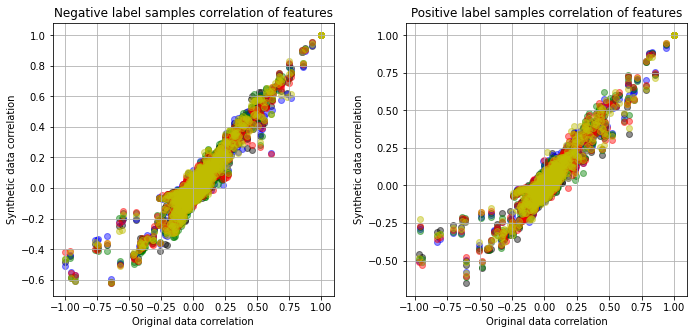

In [20]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(
        neg_correlation_original,
        neg_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax1.grid()
ax1.set_xlabel('Original data correlation')
ax1.set_ylabel('Synthetic data correlation')
ax1.set_title('Negative label samples correlation of features')

ax2 = fig.add_subplot(122)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(
        pos_correlation_original,
        pos_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax2.grid()
ax2.set_xlabel('Original data correlation')
ax2.set_ylabel('Synthetic data correlation')
ax2.set_title('Positive label samples correlation of features')

plt.tight_layout(pad=2)
plt.savefig('Output/smote_cov.png', facecolor='w', dpi=300)
plt.show()

In [21]:
r_square_neg_mean = np.mean(np.square(correl_coeff_neg))
r_square_pos_mean = np.mean(np.square(correl_coeff_pos))
r_square_neg_sem = np.std(np.square(correl_coeff_neg))/np.sqrt(number_of_runs)
r_square_pos_sem = np.std(np.square(correl_coeff_pos))/np.sqrt(number_of_runs)

print ('Corrleation of correlations (negative), mean (sem): ', end='')
print (f'{r_square_neg_mean:0.3f} ({r_square_neg_sem:0.3f})')
print ('Corrleation of correlations (positive), mean (sem): ', end = '')
print (f'{r_square_pos_mean:0.3f} ({r_square_pos_sem:0.3f})')

Corrleation of correlations (negative), mean (sem): 0.923 (0.001)
Corrleation of correlations (positive), mean (sem): 0.910 (0.002)
